In [6]:
import site
import pickle as pkl
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import copy

SPECS = {}
SPECS['all'] = ['box', 'simname', 'grid_resolution', 'snapshot', 'axis', 'path', 'mas', 'space']
SPECS['hisubhalo'] = ['model', 'HI_res', 'censat']
SPECS['galaxy'] = ['color', 'gal_species', 'gal_res', 'color_cut', 'censat']
SPECS['ptl'] = ['ptl_species']
SPECS['hiptl'] = ['model']
SPECS['vn'] = []

def siteFG():
    FGPATH = '/home/cosinga/figrid/'
    site.addsitedir(FGPATH)
    return

def loadpks(dl):
    path = '/lustre/cosinga/hcolor/output/*/results/*.pkl_rlib.pkl'
    filenames = glob.glob(path)
    total = 0
    for f in range(len(filenames)):
        fl = pkl.load(open(filenames[f], 'rb'))
        newprops = {'path':filenames[f].split('/')[5].split('_')[0]}
        if 'pk' in fl.results:
            total += len(fl.results['pk'])
            dl.loadResults(fl.results['pk'], newprops)
        print("%.2f"%(f/len(filenames)*100) + r"% loaded")
    
    return dl

def makeRSD(datalist):
    from figrid.data_container import DataContainer
    ip = {'space':'real'}
    real = datalist.getMatching(ip)
    rsdlist = []
    for dc in real:
        mattr = copy.deepcopy(dc.attrs)
        rmattr = []
        for k in mattr:
            if 'runtime' in k or 'space' in k:
                rmattr.append(k)
        for rm in rmattr:
            del mattr[rm]
        mattr['space'] = 'redshift'
        redshift = datalist.getMatching(mattr)
        if len(redshift) > 1:
            print('%d corresponding redshift-space for a real-space:'%len(redshift))
            print("real ATTRS:")
            print(dc.attrs)
            print("redshift ATTRS:")
            for r in redshift:
                print(r.attrs)
            
        elif len(redshift) == 0:
            print('no redshift space counterparts found')
            print(dc.attrs)
            continue
        else:
            redshift = redshift[0]
            data = [dc.data[0], redshift.data[1]/dc.data[1]]
            rsd = DataContainer(data)
            mattr['space'] = 'rsd' 
            rsd.update(mattr)
            rsdlist.append(rsd)
    return rsdlist

def makeBlueRedRatio(datalist):
    from figrid.data_container import DataContainer
    ip = {'color':'blue', 'color_cut':'0.60'}
    blues = datalist.getMatching(ip)
    ratiolist = []
    for dc in blues:
        mattr = copy.deepcopy(dc.attrs)
        rmattr = []
        for k in mattr:
            if 'runtime' in k or 'color' == k:
                rmattr.append(k)
        for rm in rmattr:
            del mattr[rm]
        mattr['color'] = 'red'
        reds = datalist.getMatching(mattr)
        if len(reds) > 1:
            print('%d corresponding reds for a blue:'%len(reds))
            print("BLUE ATTRS:")
            print(dc.attrs)
            print("RED ATTRS:")
            for r in reds:
                print(r.attrs)
        if len(reds) == 0:
            print('no reds found')
            print(dc.attrs)
        else:
            reds = reds[0]
            data = [dc.data[0], reds.data[1]/dc.data[1]]
            ratio = DataContainer(data)
            mattr['color'] = 'ratio' 
            ratio.update(mattr)
            ratiolist.append(ratio)
    return ratiolist

def makeBias(datalist):
    from figrid.data_container import DataContainer
    biaslist = []
    
    crosses = datalist.getMatching({'is_auto' : False, 'path':['fiducial']})
    for cx in crosses:
        fns = cx.get('fieldname').split('_')
        if 'dust' in fns:
            continue
        autos = []
        for f in fns:
            attrlist = copy.deepcopy(SPECS['all'])
            attrlist.extend(SPECS[f])
            attr = {'is_auto':True, 'fieldname':f}
            for at in attrlist:
                attr[at] = cx.get(at)
            matches = datalist.getMatching(attr)
            if len(matches)>1:
                print('too many matches %d'%len(matches))
                for m in matches:
                    print(m.attrs)
            elif len(matches) == 0:
                print('no matches found')
                print(attr)
                print(cx.attrs)
            else:
                auto = matches[0]
                data = [cx.data[0], cx.data[1] / auto.data[1]]
                dc = DataContainer(data)
                dc.update(copy.deepcopy(cx.attrs))
                dc.add('post_process', 'theory_bias')
                dc.add('numerator', cx.get('fieldname'))
                dc.add('denominator', auto.get('fieldname'))
                biaslist.append(dc)
                autos.append(auto)
        if len(autos) == 2:
            for a in range(len(autos)):
                data = [autos[a].data[0], np.sqrt(autos[a].data[1] / autos[(a+1)%2].data[1])]
                dc = DataContainer(data)
                dc.update(copy.deepcopy(cx.attrs))
                dc.add('post_process', 'obs_bias')
                dc.add('numerator', autos[a].get('fieldname'))
                dc.add('denominator', autos[(a+1)%2].get('fieldname'))
                biaslist.append(dc)

            data = [autos[0].data[0], cx.data[1] / np.sqrt(autos[0].data[1] * autos[1].data[1])]
            dc = DataContainer(data)
            dc.update(copy.deepcopy(cx.attrs))
            dc.add('post_process', 'corr_coef')
            biaslist.append(dc)
            
        del attr
    return biaslist

siteFG()
from figrid.data_sort import DataSort
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'serif'

In [7]:
def resaveSort(name):
    ds = DataSort()
    ds = loadpks(ds)
    ds.extend(makeBlueRedRatio(ds))
    ds.extend(makeRSD(ds))
    pkl.dump(ds, open(name, 'wb'), pkl.HIGHEST_PROTOCOL)
    return
# resaveSort('/lustre/cosinga/hcolor/fig_md_analysis/5-16_datasort.pkl')

In [8]:
ds = pkl.load(open('/home/cosinga/hcolor/fig_md_analysis/5-22_datasort.pkl', 'rb'))
print(ds.getAttrs())

['path', 'result_runtime', 'is_auto', 'box', 'simname', 'sim_resolution', 'num_part', 'grid_resolution', 'snapshot', 'redshift', 'axis', 'fieldname', 'is_hydrogen', 'is_atomic', 'is_molecular', 'is_particle', 'is_groupcat', 'is_matter', 'mas', 'space', 'compute_xi', 'compute_slice', 'map', 'model', 'HI_fieldname', 'color', 'gal_species', 'gal_res', 'color_cut', 'ptl_species', 'projection', 'HI_res', 'censat']


In [9]:
blist = makeBias(ds)

no matches found
{'is_auto': True, 'fieldname': 'galaxy', 'box': 75.0, 'simname': 'tng100', 'grid_resolution': 800, 'snapshot': 99, 'axis': 0, 'path': 'fiducial', 'mas': 'CICW', 'space': 'real', 'color': 'red_blue', 'gal_species': 'stmass', 'gal_res': 'diemer', 'color_cut': '0.60', 'censat': 'no key found'}
{'path': 'fiducial', 'result_runtime': 53.78528189659119, 'is_auto': False, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 99, 'redshift': 2.220446049250313e-16, 'axis': 0, 'fieldname': 'galaxy', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': False, 'is_groupcat': True, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': False, 'compute_slice': True, 'color': 'red_blue', 'gal_species': 'stmass', 'gal_res': 'diemer', 'color_cut': '0.60'}
no matches found
{'is_auto': True, 'fieldname': 'galaxy', 'box': 75.0, 'simname': 'tng100', 'grid_resolution': 800, 'snapshot': 99,

no matches found
{'is_auto': True, 'fieldname': 'galaxy', 'box': 75.0, 'simname': 'tng100', 'grid_resolution': 800, 'snapshot': 67, 'axis': 0, 'path': 'fiducial', 'mas': 'CICW', 'space': 'rsd', 'color': 'red_blue', 'gal_species': 'stmass', 'gal_res': 'diemer', 'color_cut': '0.60', 'censat': 'no key found'}
{'path': 'fiducial', 'is_auto': False, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 67, 'redshift': 0.5030475232448832, 'axis': 0, 'fieldname': 'galaxy', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': False, 'is_groupcat': True, 'is_matter': True, 'mas': 'CICW', 'compute_xi': False, 'compute_slice': True, 'color': 'red_blue', 'gal_species': 'stmass', 'gal_res': 'diemer', 'color_cut': '0.60', 'space': 'rsd'}
no matches found
{'is_auto': True, 'fieldname': 'galaxy', 'box': 75.0, 'simname': 'tng100', 'grid_resolution': 800, 'snapshot': 67, 'axis': 0, 'path': 'fiducial', 'mas': 'CI

In [10]:
ds.extend(blist)
pkl.dump(ds, open('bias_results.pkl', 'wb'), pkl.HIGHEST_PROTOCOL)

{'path': 'fiducial', 'result_runtime': 44.49701642990112, 'is_auto': True, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 99, 'redshift': 2.220446049250313e-16, 'axis': 0, 'fieldname': 'ptl', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': True, 'is_groupcat': False, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': False, 'compute_slice': True, 'ptl_species': 'dm'}


In [22]:
XLAB = 'k (cMpc/h)$^{-1}$'
YLAB = 'P$_{%s}$ (k) (cMpc/h)$^{-3}$'
ds.tickArgs({'direction':'in', 'labelsize':12})
ds.legendArgs({'frameon':False, 'loc':'upper right', 'fontsize':12}, slc = (0,0))
ds.rowLabelArgs(pos = [0.05, 0.05], txtkw = {'fontsize':14, 'ha':'left', 'va':'bottom'})
ds.colLabelArgs(pos = [0.5, 0.95], txtkw = {'fontsize':14, 'ha':'center', 'va':'top'})
ds.axisArgs({'xscale':'log', 'yscale':'log', 'xlim':[0.11866199299595938, 20]})

In [6]:
ds.setOrder('space', ['real', 'redshift', 'rsd'])
ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('snapshot', [99, 67], ['z = 0.0', 'z = 0.5'])
ds.displayAs('color', ['red', 'blue', 'resolved', 'ratio'],
            [r'Red $\times$ HI'+'\nCross-Power', r'Blue $\times$ HI'+'\nCross-Power',
            r'All $\times$ HI' + '\nCross-Power', r'Color Ratio'])
ds.displayAs('sim_resolution', ['high', 'medium', 'low'], ['TNG100-1', 'TNG100-2', 'TNG100-3'])

ds.plotArgs('color', 'red', {'color':'red'})
ds.plotArgs('color', 'blue', {'color':'blue'})
ds.plotArgs('space', 'real', {'color':'green'})
ds.plotArgs('space', 'redshift', {'color':'orange'})
ds.plotArgs('sim_resolution', 'medium', {'linestyle':'dashed'})
ds.plotArgs('sim_resolution', 'low', {'linestyle':'dotted'})
ds.plotArgs('fieldname', 'hiptl', {'color':'saddlebrown'})
ds.plotArgs('fieldname', 'hisubhalo', {'color':'sandybrown'})

# One Halo

The row values for space: ['real', 'redshift']
The column values for : ['no key found']


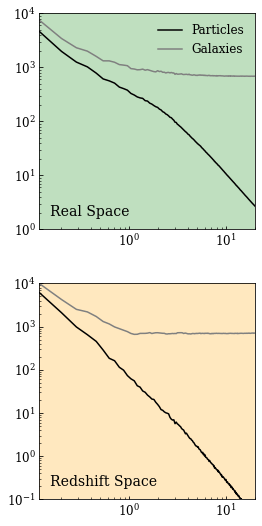

In [49]:
ip = {'is_auto':True, 'fieldname':['ptl', 'galaxy'], 
      'axis':0, 'grid_resolution':800, 
      'snapshot':99, 'color':['all', 'no key found'],
      'gal_species':['total', 'no key found'],
     'space':['real', 'redshift'], 'mas':'CICW',
     'censat':'no key found', 'ptl_species':['ptl', 'no key found'],
     'sim_resolution':'high'}

fg = ds.figrid('fieldname', 'space', '', ip)
fg.plotArgs({'fieldname':'galaxy'}, {'color':'gray', 'label':'Galaxies'})
fg.plotArgs({'fieldname':'ptl'}, {'color':'black', 'label':'Particles'})
fg.axisArgs({'ylim':[1e-1, 1e4], 'facecolor':trgba('space', 'redshift', .25)},['redshift'] )
fg.axisArgs({'ylim':[1, 1e4], 'facecolor':trgba('space', 'real', .25)},['real'] )
fg.default
fg.plot()
fg.save('onehalo/allmatterptlgal99.png')

The row values for space: ['real', 'redshift']
The column values for snapshot: [99]


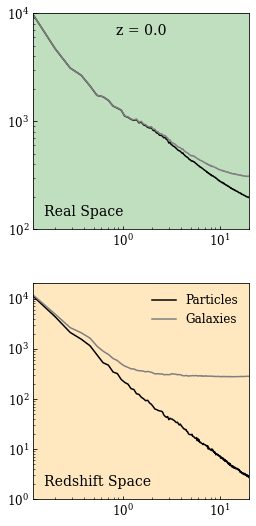

In [55]:
# LATER UPDATE TO USE TWO SNAPSHOTS
ip = {'is_auto':True, 'fieldname':['ptl', 'galaxy'], 
      'axis':0, 'grid_resolution':800, 
      'snapshot':[99], 'color':['all', 'no key found'],
      'gal_species':['stmass', 'no key found'],
     'space':['real', 'redshift'], 'mas':'CICW',
     'censat':'no key found', 'ptl_species':['stmass', 'no key found'],
     'sim_resolution':'high'}
fg2 = ds.figrid('fieldname', 'space', 'snapshot', ip)
fg2.plotArgs({'fieldname':'galaxy'}, {'color':'gray', 'label':'Galaxies'})
fg2.plotArgs({'fieldname':'ptl'}, {'color':'black', 'label':'Particles'})
fg2.axisArgs({'ylim':[1, 2e4], 'facecolor':trgba('space', 'redshift', .25)},['redshift'] )
fg2.axisArgs({'ylim':[1e2, 1e4], 'facecolor':trgba('space', 'real', .25)},['real'] )
fg2.legendArgs({}, (1,0))

fg2.plot()
fg2.save('onehalo/ptlgal_redshift.png')

# Simulation Resolution

The row values for space: ['real', 'redshift']
The column values for color: ['blue', 'red']


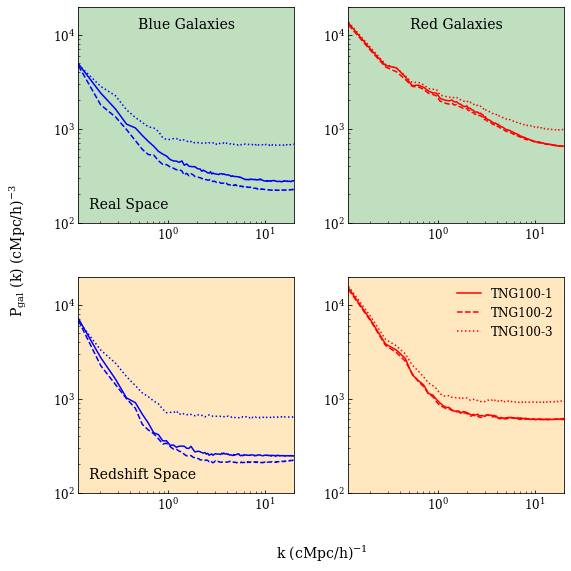

In [13]:
ip = {'is_auto':True, 'fieldname':'galaxy', 
      'axis':0, 'grid_resolution':800, 
      'snapshot':99, 'color_cut':'0.60', 'gal_res':'diemer',
      'gal_species':'stmass', 'sim_resolution':['low', 'medium', 'high'],
     'color':['blue', 'red'], 'space':['real', 'redshift'], 'mas':'CICW',
     'censat':'no key found', 'path':['fiducial', 'low-2', 'low-3']}

fg = ds.figrid('sim_resolution', 'space', 'color', ip)
fg.colLabelArgs(['Blue Galaxies', 'Red Galaxies'], textKwargs = {'ha':'center', 'fontsize':14})
fg.plotArgs({'color':'blue'}, {'color':trgba('color', 'blue')})
fg.plotArgs({'color':'red'}, {'color':trgba('color', 'red')})
fg.axisArgs({'ylim':[1e2, 2e4], 'facecolor':trgba('space', 'redshift', 0.25)})
fg.axisArgs({'facecolor':trgba('space', 'real', 0.25)}, ['real'])
fg.legendArgs({}, (1,1))
fg.plot()
fg.setXLabel(XLAB, txtargs = {'fontsize':14})
fg.setYLabel(YLAB%r"\rm{gal}", txtargs = {'fontsize':14})
fg.save('simresolution/galaxy_auto99.png')

In [14]:
ip = {'is_auto':False, 'HI_fieldname':'hiptl', 
      'axis':0, 'grid_resolution':800, 
      'snapshot':99, 'color_cut':'0.60', 'gal_res':'diemer',
      'gal_species':'stmass',
         'mas':'CICW',
         'censat':'no key found'}

spaces = ['real', 'redshift']
colors = ['red', 'blue']
paths = ['fiducial', 'low-2', 'low-3']
simres = ['high', 'medium', 'low']
for space in spaces:
    for c in range(len(colors)):
        for p in range(len(paths)):
            ip['space'] = space
            ip['color'] = colors[c]
            ip['path'] = paths[p]
            ip['sim_resolution'] = simres[p]
            matches = ds.getMatching(ip)
            ds.makeFill(ip, {'alpha':0.65})

In [15]:
%%capture
ip['figrid_process'] = 'fill'
ip['color'] = ['red', 'blue']
ip['space'] = spaces
ip['HI_fieldname'] = 'hiptl'
ip['path'] = paths
ip['sim_resolution'] = simres
fg = ds.figrid('sim_resolution', 'space', 'color', ip)
fg.legendArgs({}, (1,1))
fg.axisArgs({'ylim':(10, 1e4)}, ['real'])
fg.axisArgs({'ylim':(1e-1, 1e4)}, ['redshift'])
fg.setXLabel(XLAB, txtargs = {'fontsize':16})
sub = r'\rm{Gal} \times \rm{HI}'
fg.setYLabel(YLAB%sub, txtargs = {'fontsize':16})
fg.plot()

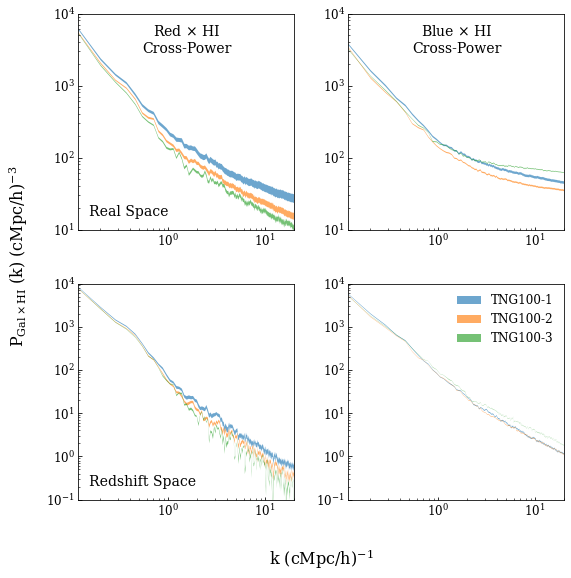

In [16]:

fg.save('simresolution/hiptlXgalaxy_99.png')
fg.fig

In [17]:
ip = {'is_auto':True, 
      'axis':0, 'grid_resolution':800, 
      'snapshot':99, 'mas':'CICW',
     'censat':'no key found'}

spaces = ['real', 'redshift']
fieldnames = ['hiptl', 'hisubhalo']
paths = ['fiducial', 'low-2', 'low-3']
simres = ['high', 'medium', 'low']
for space in spaces:
    for fn in range(len(fieldnames)):
        for p in range(len(paths)):
            ip['space'] = space
            ip['fieldname'] = fieldnames[fn]
            ip['path'] = paths[p]
            ip['sim_resolution'] = simres[p]
            matches = ds.getMatching(ip)
            ds.makeFill(ip, {'alpha':0.65})

The row values for space: ['real', 'redshift']
The column values for fieldname: ['hiptl', 'hisubhalo']


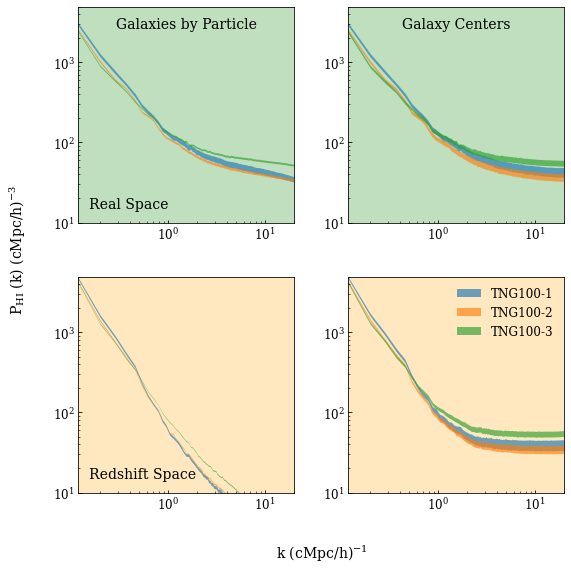

In [18]:
ip = {'is_auto':True, 
      'axis':0, 'grid_resolution':800, 
      'snapshot':99, 'mas':'CICW',
        'censat':'no key found', 'figrid_process':'fill'}

ip['space'] = ['real', 'redshift']
ip['fieldname'] = ['hiptl', 'hisubhalo']
ip['path'] = ['fiducial', 'low-2', 'low-3']
ip['sim_resolution'] = ['high', 'medium', 'low']

fg = ds.figrid('sim_resolution', 'space', 'fieldname', ip)
fg.colLabelArgs(['Galaxies by Particle', 'Galaxy Centers'], textKwargs = {'ha':'center', 'fontsize':14})
fg.plotArgs({'color':'blue'}, {'color':trgba('color', 'blue')})
fg.plotArgs({'color':'red'}, {'color':trgba('color', 'red')})
fg.axisArgs({'ylim':[10, 5e3], 'facecolor':trgba('space', 'redshift', 0.25)})
fg.axisArgs({'facecolor':trgba('space', 'real', 0.25)}, ['real'])
fg.legendArgs({}, (1,1))
fg.plot()
fg.setXLabel(XLAB, txtargs = {'fontsize':14})
fg.setYLabel(YLAB%r"\rm{HI}", txtargs = {'fontsize':14})
fg.save('simresolution/HI_auto99.png')